# Project
## Neural translation model

In this notebook, we will create a neural network that translates from English to German.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
from IPython.display import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

For this project, we will use a language dataset from http://www.manythings.org/anki/ to build a neural translation model. This dataset consists of over 200,000 pairs of sentences in English and German. In order to make the training quicker, we will restrict to our dataset to 20,000 pairs.

our goal is to develop a neural translation model from English to German, making use of a pre-trained English word embedding module.

In [ ]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Import the data

The dataset is available for download as a zip file at the following link:

https://drive.google.com/open?id=1KczOciG7sYY7SB9UlBeRP1T9659b121Q


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://drive.google.com/u/0/uc?id=1KczOciG7sYY7SB9UlBeRP1T9659b121Q&export=download

--2021-03-05 16:12:20--  https://drive.google.com/u/0/uc?id=1KczOciG7sYY7SB9UlBeRP1T9659b121Q
Resolving drive.google.com (drive.google.com)... 74.125.142.113, 74.125.142.100, 74.125.142.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/veuelc2l1944mjk6iqeqr53bsmjqoj15/1614960675000/05966119998589466355/*/1KczOciG7sYY7SB9UlBeRP1T9659b121Q [following]
--2021-03-05 16:12:22--  https://doc-10-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/veuelc2l1944mjk6iqeqr53bsmjqoj15/1614960675000/05966119998589466355/*/1KczOciG7sYY7SB9UlBeRP1T9659b121Q
Resolving doc-10-64-docs.googleusercontent.com (doc-10-64-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-10-64-docs.googleusercontent.com (doc-10-64-docs.googleusercontent.com)|74.

In [ ]:
# Run this cell to load the dataset

NUM_EXAMPLES = 20000
data_examples = []
with open("/content/deu.txt", 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [ ]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

#### The custom translation model
The following is a schematic of the custom translation model architecture we will develop in this project.

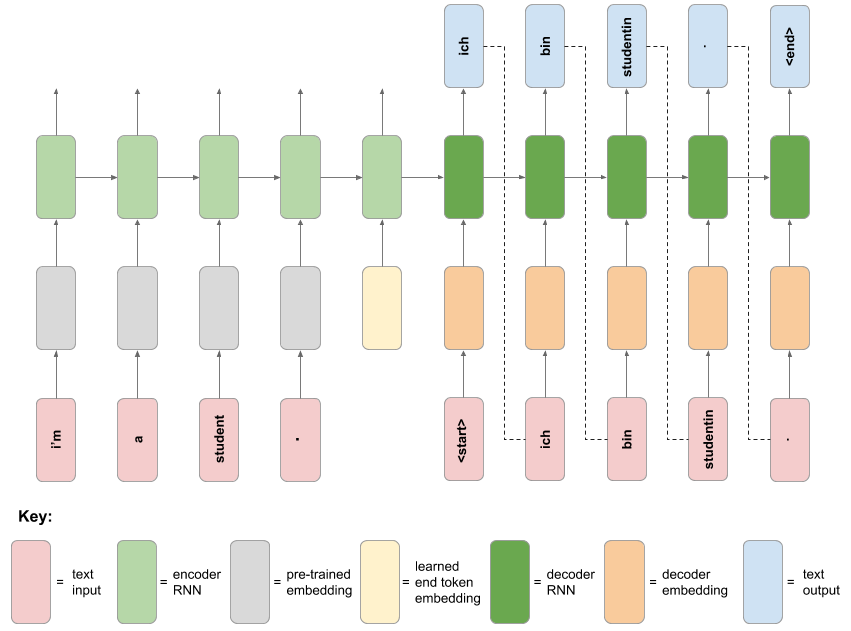

In [ ]:
# Run this cell to download and view a schematic diagram for the neural translation model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1XsS1VlXoaEo-RbYNilJ9jcscNZvsSPmd"
Image("neural_translation_model.png")

The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A start token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text preprocessing


In [ ]:
english_sentences = []
german_sentences = []

for i in range(len(data_examples)):
  english_sentences.append((preprocess_sentence(re.split('\t', data_examples[i])[0])))
  german_sentences.append('<start> ' + (preprocess_sentence(re.split('\t', data_examples[i])[1])) + ' <end>')

In [ ]:
import json

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                  num_words=None)

tokenizer.fit_on_texts(german_sentences)
tokenizer_config = tokenizer.get_config()

index_word = json.loads(tokenizer_config['index_word'])
word_index = json.loads(tokenizer_config['word_index'])

print(word_index.get('.'))
print(word_index.get('!'))

3
9


In [ ]:
german_sentences_seq = tokenizer.texts_to_sequences(german_sentences)

In [ ]:
import numpy as np

num_samples = 5

inx = np.random.choice(len(english_sentences), num_samples, replace=False)
print(inx)

for i, (chunk1, chunk2, chunk3) in enumerate(zip(np.array(english_sentences)[inx], np.array(german_sentences)[inx], np.array(german_sentences_seq)[inx])):
  print(i, chunk1)
  print(i, chunk2, chunk3)

[11264 16803  3852  1088  5549]
0 keep the change .
0 <start> behalte das wechselgeld . <end> [1, 1792, 11, 2148, 3, 2]
1 tom kept sighing .
1 <start> tom seufzte vor sich hin . <end> [1, 5, 1495, 164, 34, 205, 3, 2]
2 that was tom .
2 <start> das war tom . <end> [1, 11, 24, 5, 3, 2]
3 he is busy .
3 <start> er ist beschaeftigt . <end> [1, 14, 6, 98, 3, 2]
4 my dog is big .
4 <start> mein hund ist gross . <end> [1, 50, 107, 6, 167, 3, 2]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
german_sentences_seq_padded = tf.keras.preprocessing.sequence.pad_sequences(german_sentences_seq, 
                                                                            maxlen=None,
                                                                            padding='post',
                                                                            value=0)

In [ ]:
german_sentences_seq_padded.shape

(20000, 14)

## 2. Prepare the data

#### Load the embedding layer
As part of the dataset preproceessing for this project, we will use a pre-trained English word embedding module from TensorFlow Hub. The URL for the module is https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1.

This embedding takes a batch of text tokens in a 1-D tensor of strings as input. It then embeds the separate tokens into a 128-dimensional space. 

The code to load and test the embedding layer is provided for you below.

**NB:** this model can also be used as a sentence embedding module. The module will process each token by removing punctuation and splitting on spaces. It then averages the word embeddings over a sentence to give a single embedding vector. However, we will use it only as a word embedding module, and will pass each word in the input sentence as a separate token.

In [ ]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [ ]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

We should now prepare the training and validation Datasets.

* Create a random training and validation set split of the data, reserving e.g. 20% of the data for validation (NB: each English dataset example is a single sentence string, and each German dataset example is a sequence of padded integer tokens).
* Load the training and validation sets into a tf.data.Dataset object, passing in a tuple of English and German data for both training and validation sets.
* Create a function to map over the datasets that splits each English sentence at spaces. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.strings.split function._
* Create a function to map over the datasets that embeds each sequence of English words using the loaded embedding layer/model. Apply this function to both Dataset objects using the map method.
* Create a function to filter out dataset examples where the English sentence is greater than or equal to than 13 (embedded) tokens in length. Apply this function to both Dataset objects using the filter method.
* Create a function to map over the datasets that pads each English sequence of embeddings with some distinct padding value before the sequence, so that each sequence is length 13. Apply this function to both Dataset objects using the map method.
* Batch both training and validation Datasets with a batch size of 16.
* Print the `element_spec` property for the training and validation Datasets. 
* Using the Dataset `.take(1)` method, print the shape of the English data example from the training Dataset.
* Using the Dataset `.take(1)` method, print the German data example Tensor from the validation Dataset.

In [ ]:
from sklearn.model_selection import train_test_split

x_english_train, x_english_test = train_test_split(english_sentences, test_size = 0.2, random_state = 0)
x_german_tokenised_train, x_german_tokenised_test = train_test_split(german_sentences_seq_padded, test_size = 0.2, random_state = 0)

In [ ]:
x_english_train = np.array(x_english_train)
x_english_test = np.array(x_english_test)

x_german_tokenised_train = np.array(x_german_tokenised_train)
x_german_tokenised_test = np.array(x_german_tokenised_test)

training_dataset = tf.data.Dataset.from_tensor_slices((x_english_train, x_german_tokenised_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((x_english_test, x_german_tokenised_test))

print(training_dataset.element_spec)
print(validation_dataset.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))


In [ ]:
def map_split_func(x,y):
  inp = []

  inp.append(tf.strings.split(x,' '))
  inp.append(y)

  return inp[0], inp[1]
  
training_dataset = training_dataset.map(map_split_func)
validation_dataset = validation_dataset.map(map_split_func)

In [ ]:
def map_embeddings_func(x,y):
  inp = []
  inp.append(embedding_layer(x))
  inp.append(y)
  return inp[0], inp[1]

training_dataset = training_dataset.map(map_embeddings_func)
validation_dataset = validation_dataset.map(map_embeddings_func)
print(training_dataset.element_spec)
print(validation_dataset.element_spec)

(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))


In [ ]:
training_dataset = training_dataset.filter(lambda x, y: False if ((tf.shape(x)[0])>13) else True)
validation_dataset = validation_dataset.filter(lambda x, y: False if ((tf.shape(x)[0])>13) else True)

In [ ]:
def map_pad_embeddings_func(x,y):
  inp = []
  pad = tf.pad(x,paddings=[[13-tf.shape(x)[0],0],[0,0]], mode='CONSTANT', constant_values=1.0, name=None)
  inp.append(pad)
  inp.append(y)
  return inp[0], inp[1]


training_dataset = training_dataset.map(map_pad_embeddings_func)
validation_dataset = validation_dataset.map(map_pad_embeddings_func)
print(training_dataset.element_spec)
print(validation_dataset.element_spec)

(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))


In [ ]:
# Batching
training_dataset = training_dataset.batch(16)
validation_dataset = validation_dataset.batch(16)

## 3. Create the custom layer
We will now create a custom layer to add the learned end token embedding to the encoder model:

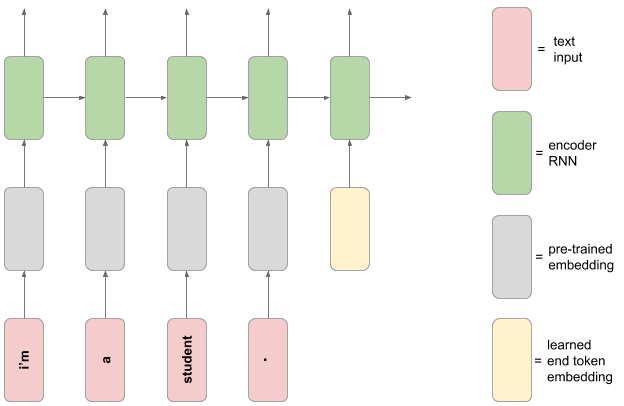

In [ ]:
# Run this cell to download and view a schematic diagram for the encoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1JrtNOzUJDaOWrK4C-xv-4wUuZaI12sQI"
Image("neural_translation_model.png")

We should now build the custom layer.
* Using layer subclassing, create a custom layer that takes a batch of English data examples from one of the Datasets, and adds a learned embedded ‘end’ token to the end of each sequence. 
* This layer should create a TensorFlow Variable (that will be learned during training) that is 128-dimensional (the size of the embedding space).


In [ ]:
class MyLayer(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(MyLayer, self).__init__(**kwargs)
    self.embedding = tf.Variable(initial_value = tf.random.normal(shape=(128,)), trainable=True)
  
  def call(self, input):
    num_of_samples = tf.shape(input)[0]
    embedding_shape = tf.shape(self.embedding)[0]
    output = tf.tile(input=tf.reshape(self.embedding, [1, 1, embedding_shape]), multiples=[num_of_samples, 1, 1])
    return tf.keras.layers.concatenate([input, output], axis=1)

In [ ]:
mylayer = MyLayer()

## 4. Build the encoder network
The encoder network follows the schematic diagram above. You should now build the RNN encoder model.
* Using the functional API, build the encoder network according to the following spec:
    * The model will take a batch of sequences of embedded English words as input, as given by the Dataset objects.
    * The next layer in the encoder will be the custom layer you created previously, to add a learned end token embedding to the end of the English sequence.
    * This is followed by a Masking layer, with the `mask_value` set to the distinct padding value you used when you padded the English sequences with the Dataset preprocessing above.
    * The final layer is an LSTM layer with 512 units, which also returns the hidden and cell states.
    * The encoder is a multi-output model. There should be two output Tensors of this model: the hidden state and cell states of the LSTM layer. The output of the LSTM layer is unused.


In [ ]:
def MyEncModel(input_shape):
  input = tf.keras.layers.Input(shape=input_shape)
  h = MyLayer()(input)
  h = tf.keras.layers.Masking(mask_value=0)(h)
  output, hidden_state, cell_state = tf.keras.layers.LSTM(512, return_state=True)(h)
  model = tf.keras.Model(input, [hidden_state, cell_state])
  return model

In [ ]:
seq_len = 13
embedding_len = 128
enc_model = MyEncModel((seq_len, embedding_len))

In [ ]:
eng_batch = next(iter(training_dataset.take(1)))[0]
hidden_states, cell_states = enc_model(eng_batch)
print(f"Shape of Hidden States: {hidden_states.shape}.\nShape of cell states: {cell_states.shape}")

Shape of Hidden States: (16, 512).
Shape of cell states: (16, 512)


In [ ]:
enc_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13, 128)]         0         
_________________________________________________________________
my_layer_1 (MyLayer)         (None, 14, 128)           128       
_________________________________________________________________
masking (Masking)            (None, 14, 128)           0         
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


## 5. Build the decoder network
The decoder network follows the schematic diagram below. 

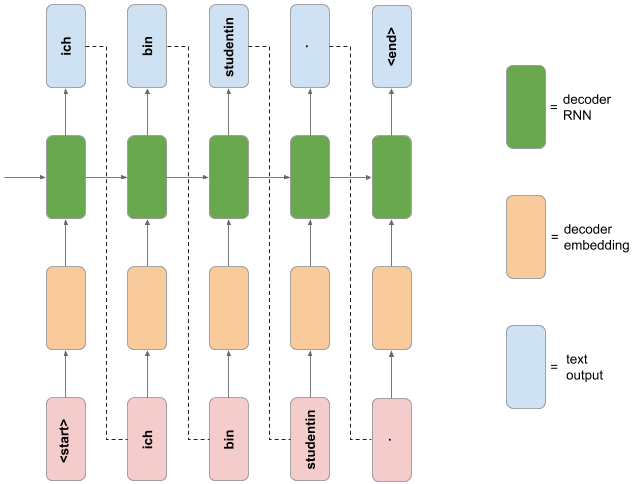

In [ ]:
# Run this cell to download and view a schematic diagram for the decoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1DTeaXD8tA8RjkpVrB2mr9csSBOY4LQiW"
Image("neural_translation_model.png")

We should now build the RNN decoder model.
  * An Embedding layer with vocabulary size set to the number of unique German tokens, embedding dimension 128, and set to mask zero values in the input.
  * An LSTM layer with 512 units, that returns its hidden and cell states, and also returns sequences.
  * A Dense layer with number of units equal to the number of unique German tokens, and no activation function.


In [ ]:
class MyDecModel(tf.keras.Model):

  def __init__(self, **kwargs):
    super(MyDecModel, self).__init__(**kwargs)
    input_dim = len(tokenizer.word_index)+1
    self.embedding = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=128, mask_zero=True)
    self.lstm = tf.keras.layers.LSTM(512, return_sequences=True, return_state=True)
    self.dense = tf.keras.layers.Dense(len(tokenizer.word_index)+1)

  def call(self, input, hidden_state=None, cell_state=None):
    x = self.embedding(input)
    x, hidden, cell = self.lstm(x, initial_state=[hidden_state, cell_state])
    x = self.dense(x)
    return x, hidden, cell

In [ ]:
dec_model = MyDecModel()

In [ ]:
sample_en, sample_de = next(iter(training_dataset.take(1)))
h, c = enc_model(sample_en)
out, hout, cout = dec_model(sample_de, h, c)
print(f"Output shape: {out.shape}\nHidden state shape: {hout.shape}\nCell state shape: {cout.shape}\n")

Output shape: (16, 14, 5744)
Hidden state shape: (16, 512)
Cell state shape: (16, 512)



In [ ]:
dec_model.summary()

Model: "my_dec_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  735232    
_________________________________________________________________
lstm_1 (LSTM)                multiple                  1312768   
_________________________________________________________________
dense (Dense)                multiple                  2946672   
Total params: 4,994,672
Trainable params: 4,994,672
Non-trainable params: 0
_________________________________________________________________


## 6. Make a custom training loop
We should now write a custom training loop to train your custom neural translation model.
* Function that takes a Tensor batch of German data (as extracted from the training Dataset), and returns a tuple containing German inputs and outputs for the decoder model (refer to schematic diagram above).
* Function that computes the forward and backward pass for your translation model. This function should take an English input, German input and German output as arguments, and should do the following:
    * Pass the English input into the encoder, to get the hidden and cell states of the encoder LSTM.
    * These hidden and cell states are then passed into the decoder, along with the German inputs, which returns a sequence of outputs (the hidden and cell state outputs of the decoder LSTM are unused in this function).
    * The loss should then be computed between the decoder outputs and the German output function argument.
    * The function returns the loss and gradients with respect to the encoder and decoder’s trainable variables.
    * Decorate the function with `@tf.function`
* Define and run a custom training loop for a number of epochs that does the following:
    * Iterates through the training dataset, and creates decoder inputs and outputs from the German sequences.
    * Updates the parameters of the translation model using the gradients of the function above and an optimizer object.
    * Every epoch, compute the validation loss on a number of batches from the validation and save the epoch training and validation losses.
* Plot the learning curves for loss vs epoch for both training and validation sets.

In [ ]:
lf = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam()

In [ ]:
@tf.function
def loss_opt_fun(en_in, de_in, de_out, loss_f):
  with tf.GradientTape() as g:
    enc_hs, enc_cs = enc_model(en_in)
    dec_out, dec_hs, dec_cs = dec_model(de_in, enc_hs, enc_cs)
    loss = tf.math.reduce_mean(loss_f(de_out, dec_out))
    trainables = enc_model.trainable_variables + dec_model.trainable_variables
    grads = g.gradient(loss, trainables)
    return loss, grads

In [ ]:
loss_train = []
loss_val = []

for epoch in range(10):
  loss_batch = []

  for en, de in training_dataset:
    decoder_inputs, decoder_outputs = de[:, :-1], de[:, 1:]
    loss, grads = loss_opt_fun(en, decoder_inputs, decoder_outputs, lf)
    opt.apply_gradients(zip(grads, enc_model.trainable_variables + dec_model.trainable_variables))
    loss_batch += [loss]

  loss_train.append(np.mean(loss_batch))
  print(f"Epoch {epoch};\t", end="")

  loss_batch = []

  for en, de in validation_dataset:
    (decoder_inputs, decoder_outputs) = de[:, :-1], de[:, 1:]
    loss, grads = loss_opt_fun(en, decoder_inputs, decoder_outputs, lf)
    loss_batch += [loss]

  loss_val.append(np.mean(loss_batch))

  print(f"Loss train {loss_train[-1]};\tLoss val {loss_val[-1]}")

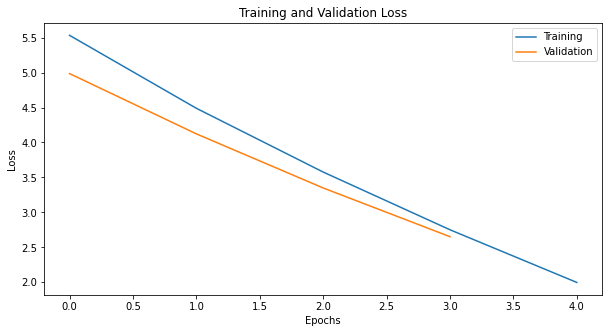

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(loss_train)
plt.plot(loss_val)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training', 'Validation'])
plt.show()

## 7. Use the model to translate
Now it's time to put our model into practice! For each sentence, the process is as follows:
* Preprocess and embed the English sentence according to the model requirements.
* Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
* Starting with the special  `"<start>"` token, use this token and the final encoder hidden and cell states to get the one-step prediction from the decoder, as well as the decoder’s updated hidden and cell states.
* Create a loop to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. Terminate the loop when the `"<end>"` token is emitted, or when the sentence has reached a maximum length.
* Decode the output token sequence into German text and print the English text and the model's German translation.

In [ ]:
sample_index = np.random.choice(len(german_sentences), size=5, replace=False)

de_sentences = [preprocess_sentence(data.split("\t")[1]) for data in data_examples]
en_sentences = [preprocess_sentence(data.split("\t")[0]) for data in data_examples]

for i in sample_index:
  input_sentence = en_sentences[i]
  gt = de_sentences[i]

  input_split, _ = map_split_func(input_sentence, None)
  embed_input, _ = map_embeddings_func(input_split, None)
  padded_input, _ = map_pad_embeddings_func(embed_input, None)
  hidden_states, cell_states = enc_model(tf.expand_dims(padded_input, 0))

  prev_word = tf.Variable([[tokenizer.word_index['<start>']]])

  output = []
  while len(output) < 15:
    dec_out, hidden_states, cell_states = dec_model(prev_word, hidden_states, cell_states)
    dec_out = tf.squeeze(tf.argmax(dec_out, axis=2)).numpy()

    if dec_out == tokenizer.word_index['<end>']:
      break

    output.append(tokenizer.index_word[dec_out])
    prev_word = tf.Variable([[dec_out]])

  translated_sentence = ' '.join(output)
  print(f"Input: {input_sentence} Translated: {translated_sentence} Ground Truth: {gt}")
  print("--------------")

Input: you're back . Translated: du bist am groessten . Ground Truth: sie sind zurueck .
--------------
Input: she came last . Translated: sie hat zwei gegessen . Ground Truth: sie wurde letzte .
--------------
Input: i didn't order it . Translated: ich habe es nicht gesehen . Ground Truth: ich habe sie nicht bestellt .
--------------
Input: it's ready . Translated: es ist zu bezweifeln . Ground Truth: es ist bereit .
--------------
Input: tom gave me that . Translated: tom hat mich enttaeuscht . Ground Truth: tom hat mir das gegeben .
--------------
